## Setup

In [1]:
import pandas as pd
import numpy as np

import scipy.sparse

from sklearn.metrics import (confusion_matrix, precision_recall_curve, 
                            precision_score, recall_score, accuracy_score,
                            roc_curve, roc_auc_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate


%matplotlib inline
from matplotlib import pyplot as plt

import jellyfish

In [2]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    plt.ylim([0, 1])

In [3]:
def print_thresholds_stats(y_true, y_pred, min_threshold, max_threshold, num=20):
    """Print out accuracy, precision, recall, and confusion counts."""
    print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
    for cutoff in np.linspace(min_threshold, max_threshold, num=num):
        y_train_pred = (y_pred > cutoff)
        print('{:.3f}'.format(cutoff), end='\t')
        print('{:.3f}'.format(accuracy_score(y_true, y_train_pred)), end='\t')
        print('{:.3f}'.format(precision_score(y_true, y_train_pred)), end='\t')
        print('{:.3f}'.format(recall_score(y_true, y_train_pred)), end='\t')
        tn, fp, fn, tp = confusion_matrix(y_true, y_train_pred).ravel()
        print(sum(y_train_pred), end='\t\t')
        print(fp, end='\t')
        print(fn, end='\t')
        print(tp, end='\t')
        print(tn)

In [4]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Training Dataset

### Load training data

In [5]:
df_full = pd.read_csv('../data/real_data/copd_train.csv', sep='^', header=None, names=['Text', 'COPD'])

# Lowercase data
df_full['Text2'] = df_full.Text.str.lower()

# Drop duplicates
df__no_dupes = df_full.drop_duplicates().copy().reset_index()

### TFIDF

In [6]:
# Create TF-IDF object that split data into sublists from a single word to four words (4-gram)
tfidf = TfidfVectorizer(ngram_range=(1,4))

mat_0 = tfidf.fit_transform(df__no_dupes.Text2)

voc_reverse = {v:k for k,v in tfidf.vocabulary_.items()}

### Distance features

Engineer features that capture the edit distance from the four proxy terms.

In [7]:
df__no_dupes['jaro_copd'] = df__no_dupes.Text2.map(lambda s: jellyfish.jaro_winkler('copd', s))

df__no_dupes['jaro_copd_full'] = df__no_dupes.Text2.map(lambda s: jellyfish.jaro_winkler('chronic obstructive pulmonary disease', s))

df__no_dupes['dl_copd'] = df__no_dupes.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('copd', s) / max(len('copd'), len(s))))

df__no_dupes['dl_copd_full'] = df__no_dupes.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('chronic obstructive pulmonary disease', s) / max(len('chronic obstructive pulmonary disease'), len(s))))

Combine the new distance features with the TF-IDF matrix created earlier.

In [12]:
distance_cols = ['jaro_copd', 'jaro_copd_full', 'dl_copd', 'dl_copd_full']

mat = scipy.sparse.hstack([mat_0, df__no_dupes[distance_cols].values])

### Logistic Regression

#### Look at cross validated metrics

In [13]:
lr = LogisticRegressionCV()

r = cross_validate(lr, 
               X=mat, 
               y=df__no_dupes.COPD, 
               scoring=['accuracy', 'precision', 'recall'], 
               return_train_score=True)
r

{'fit_time': array([9.0096662 , 7.34407997, 7.11128092]),
 'score_time': array([0.00874496, 0.00651884, 0.00566125]),
 'test_accuracy': array([0.99587242, 0.99530869, 0.99455808]),
 'test_precision': array([0.94444444, 0.97315436, 0.99280576]),
 'test_recall': array([0.92168675, 0.87349398, 0.8313253 ]),
 'train_accuracy': array([0.99990617, 1.        , 1.        ]),
 'train_precision': array([1., 1., 1.]),
 'train_recall': array([0.99698795, 1.        , 1.        ])}

In [14]:
pd.DataFrame(r)[['test_accuracy', 'test_precision', 'test_recall']].mean()

test_accuracy     0.995246
test_precision    0.970135
test_recall       0.875502
dtype: float64

#### Get cross validated predctions, decision scores, and predicted probabilites

In [15]:
labels = cross_val_predict(lr, mat, df__no_dupes.COPD)
decision_scores = cross_val_predict(lr, mat, df__no_dupes.COPD, method='decision_function')
proba = cross_val_predict(lr, mat, df__no_dupes.COPD, method='predict_proba')

In [16]:
df__no_dupes['log_reg'] = labels
df__no_dupes['decision_function'] = decision_scores
df__no_dupes['predict_proba__1'] = proba[:,1]

In [43]:
y_true = df__no_dupes.COPD
y_pred_classes = labels

print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
print('{:.3f}'.format(.5), end='\t')
print('{:.3f}'.format(accuracy_score(y_true, y_pred_classes)), end='\t')
print('{:.3f}'.format(precision_score(y_true, y_pred_classes)), end='\t')
print('{:.3f}'.format(recall_score(y_true, y_pred_classes)), end='\t')
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()
print(sum(y_pred_classes), end='\t\t')
print(fp, end='\t')
print(fn, end='\t')
print(tp, end='\t')
print(tn)

cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.500	0.995	0.969	0.876	450		14	62	436	15476


#### Precision Recall chart

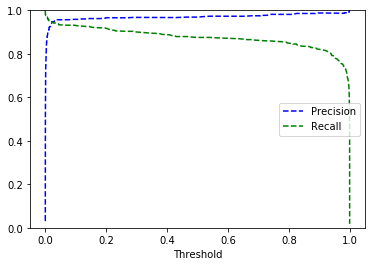

In [17]:
precisions, recalls, thresholds = precision_recall_curve(y_true=df__no_dupes.COPD, 
                                                         probas_pred=df__no_dupes.predict_proba__1) # decision_function or predict_probas

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

View metrics for various threshold values

In [18]:
print_thresholds_stats(df__no_dupes.COPD, df__no_dupes['predict_proba__1'], 0, .1)

cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.000	0.031	0.031	1.000	15988		15490	0	498	0
0.005	0.995	0.872	0.970	554		71	15	483	15419
0.011	0.996	0.908	0.956	524		48	22	476	15442
0.016	0.996	0.926	0.950	511		38	25	473	15452
0.021	0.997	0.944	0.948	500		28	26	472	15462
0.026	0.997	0.947	0.942	495		26	29	469	15464
0.032	0.997	0.953	0.942	492		23	29	469	15467
0.037	0.997	0.953	0.942	492		23	29	469	15467
0.042	0.997	0.957	0.938	488		21	31	467	15469
0.047	0.997	0.957	0.932	485		21	34	464	15469
0.053	0.997	0.957	0.932	485		21	34	464	15469
0.058	0.997	0.957	0.932	485		21	34	464	15469
0.063	0.997	0.957	0.932	485		21	34	464	15469
0.068	0.997	0.957	0.932	485		21	34	464	15469
0.074	0.997	0.959	0.932	484		20	34	464	15470
0.079	0.997	0.959	0.932	484		20	34	464	15470
0.084	0.997	0.959	0.932	484		20	34	464	15470
0.089	0.997	0.959	0.932	484		20	34	464	15470
0.095	0.997	0.959	0.932	484		20	34	464	15470
0.100	0.997	0.959	0.930	483		20	35	463	15470


In [19]:
SELECTED_THRESHOLD = .005

#### ROC curve

In [20]:
fpr, tpr, thresholds = roc_curve(y_true=df__no_dupes.COPD, y_score=df__no_dupes.decision_function)

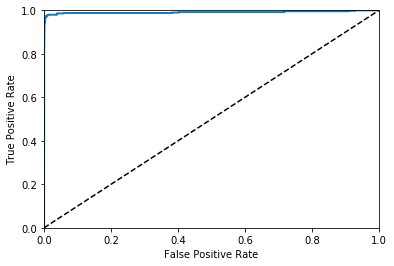

In [21]:
plot_roc_curve(fpr, tpr)
plt.show()

In [22]:
roc_auc_score(y_true=df__no_dupes.COPD, y_score=df__no_dupes.decision_function)

0.9911798906406777

#### Train final model on all training data

This is the trained classifier that will be used on the test dataset.

In [23]:
lr = LogisticRegressionCV()

In [24]:
lr.fit(X=mat, y=df__no_dupes.COPD)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

## Test Dataset

In [25]:
df_full_test = pd.read_csv('../data/real_data/copd_test.csv', sep='^', header=None, names=['Text', 'COPD'])

# Lowercase data
df_full_test['Text2'] = df_full_test.Text.str.lower()

# Drop duplicates
df__no_dupes_test = df_full_test.drop_duplicates().copy().reset_index()

### TFIDF

In [26]:
# Use the same TF-IDF object on the test data that was trained on the training data
mat_test_0 = tfidf.transform(df__no_dupes_test.Text2)

### Distance features

Engineer features that capture the edit distance from the four proxy terms.

In [27]:
df__no_dupes_test['jaro_copd'] = df__no_dupes_test.Text2.map(lambda s: jellyfish.jaro_winkler('copd', s))

df__no_dupes_test['jaro_copd_full'] = df__no_dupes_test.Text2.map(lambda s: jellyfish.jaro_winkler('chronic obstructive pulmonary disease', s))

df__no_dupes_test['dl_copd'] = df__no_dupes_test.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('copd', s) / max(len('copd'), len(s))))

df__no_dupes_test['dl_copd_full'] = df__no_dupes_test.Text2.map(lambda s: 1 - (jellyfish.damerau_levenshtein_distance('chronic obstructive pulmonary disease', s) / max(len('chronic obstructive pulmonary disease'), len(s))))

Combine the new distance features with the TF-IDF matrix created earlier.

In [28]:
mat_test = scipy.sparse.hstack([mat_test_0, df__no_dupes_test[distance_cols].values])

### Predict on Test data

In [29]:
y_test_pred = lr.predict_proba(mat_test)

In [40]:
y_test_pred_classes = (y_test_pred[:,1] > SELECTED_THRESHOLD).astype(int)

In [34]:
y_test_true = df__no_dupes_test.COPD

In [41]:
print('cutoff\tacc\tprec\trecall\tpos_count\tFP\tFN\tTP\tTN')
print('{:.3f}'.format(SELECTED_THRESHOLD), end='\t')
print('{:.3f}'.format(accuracy_score(y_test_true, y_test_pred_classes)), end='\t')
print('{:.3f}'.format(precision_score(y_test_true, y_test_pred_classes)), end='\t')
print('{:.3f}'.format(recall_score(y_test_true, y_test_pred_classes)), end='\t')
tn, fp, fn, tp = confusion_matrix(y_test_true, y_test_pred_classes).ravel()
print(sum(y_test_pred_classes), end='\t\t')
print(fp, end='\t')
print(fn, end='\t')
print(tp, end='\t')
print(tn)

cutoff	acc	prec	recall	pos_count	FP	FN	TP	TN
0.005	0.987	0.709	1.000	275		80	0	195	5868
